# Notebook 05 — Paper Simulation (Mensal)

Objetivo:
Simular uma estratégia operacional, mais próxima do “mundo real”:

- Sinal no último pregão do mês (usando previsões OOS)
- Execução no pregão seguinte na abertura
- Carteira Top-K equal-weight (long-only) e opcional long-short
- Custos e slippage aplicados por turnover e por operação

Saídas:
- Série mensal de retornos (gross/net)
- Equity curve
- Turnover médio e custos
- Diagnósticos (quantos ativos, meses válidos, etc.)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PRED_PATH = "../data/processed/preds_oos_tree.parquet"     # ou preds_oos_linear.parquet se quiser comparar
PRICES_PATH = "../data/processed/ibov_top40_features.parquet"

assert os.path.exists(PRED_PATH), f"Não encontrei {PRED_PATH}"
assert os.path.exists(PRICES_PATH), f"Não encontrei {PRICES_PATH}"

preds = pd.read_parquet(PRED_PATH).copy()
px = pd.read_parquet(PRICES_PATH).copy()

preds["date"] = pd.to_datetime(preds["date"])
px["date"] = pd.to_datetime(px["date"])

preds["ticker"] = preds["ticker"].astype(str).str.upper().str.strip()
px["ticker"] = px["ticker"].astype(str).str.upper().str.strip()

preds["year_month"] = preds["date"].dt.to_period("M")
px = px.sort_values(["ticker", "date"]).reset_index(drop=True)

print("preds:", preds.shape, "| months:", preds["year_month"].nunique())
print("px   :", px.shape, "| tickers:", px["ticker"].nunique())

preds: (156068, 6) | months: 251
px   : (176097, 38) | tickers: 38


In [2]:
# Para cada (mês, ticker): usar a ÚLTIMA previsão disponível do mês como "sinal"
signals = (
    preds.sort_values(["year_month", "ticker", "date"])
         .groupby(["year_month", "ticker"], as_index=False)
         .last()
)

# signals tem: year_month, ticker, date (último pregão do mês), y_pred, y_true, ...
signals = signals[["year_month", "ticker", "date", "y_pred"]].copy()
signals = signals.rename(columns={"date": "signal_date"})

print("signals:", signals.shape)
signals.head()

signals: (7635, 4)


,year_month,ticker,signal_date,y_pred
0,2005-03,ABEV3,2005-03-31 03:00:00,0.798364
1,2005-03,AXIA3,2005-03-31 03:00:00,0.026860
2,2005-03,AXIA6,2005-03-31 03:00:00,-0.004744
3,2005-03,BBAS3,2005-03-31 03:00:00,0.039408
4,2005-03,BBDC3,2005-03-31 03:00:00,0.030991


In [3]:
# Criar next_open por ticker (pregão seguinte)
px_exec = px[["date", "ticker", "open"]].copy()
px_exec["next_date"] = px_exec.groupby("ticker")["date"].shift(-1)
px_exec["next_open"] = px_exec.groupby("ticker")["open"].shift(-1)

# Mapear: signal_date + ticker -> entry_date/entry_open
px_entry = px_exec.rename(columns={"date": "signal_date", "next_date": "entry_date", "next_open": "entry_open"})
px_entry = px_entry[["signal_date", "ticker", "entry_date", "entry_open"]].copy()

# juntar entry info
signals = signals.merge(px_entry, on=["signal_date", "ticker"], how="left")

# remover casos sem próximo pregão (fim do histórico)
signals = signals.dropna(subset=["entry_date", "entry_open"]).copy()

print("signals pós entry merge:", signals.shape)
signals.head()

signals pós entry merge: (7635, 6)


,year_month,ticker,signal_date,y_pred,entry_date,entry_open
0,2005-03,ABEV3,2005-03-31 03:00:00,0.798364,2005-04-01 03:00:00,3.1440
1,2005-03,AXIA3,2005-03-31 03:00:00,0.026860,2005-04-01 03:00:00,18.2700
2,2005-03,AXIA6,2005-03-31 03:00:00,-0.004744,2005-04-01 03:00:00,17.4500
3,2005-03,BBAS3,2005-03-31 03:00:00,0.039408,2005-04-01 03:00:00,4.9817
4,2005-03,BBDC3,2005-03-31 03:00:00,0.030991,2005-04-01 03:00:00,15.4545


In [4]:
# Para obter saída: precisamos do entry_open do PRÓXIMO mês como exit_open deste mês
signals = signals.sort_values(["ticker", "year_month"]).reset_index(drop=True)

# exit é o entry do mês seguinte do mesmo ticker
signals["exit_date"] = signals.groupby("ticker")["entry_date"].shift(-1)
signals["exit_open"] = signals.groupby("ticker")["entry_open"].shift(-1)

# retorno realizado da posição = exit_open / entry_open - 1
signals["ret_realized"] = (signals["exit_open"] / signals["entry_open"]) - 1

# remover últimos meses sem saída
signals = signals.dropna(subset=["exit_date", "exit_open", "ret_realized"]).copy()

print("signals com retorno realizado:", signals.shape)
signals.head()

signals com retorno realizado: (7597, 9)


,year_month,ticker,signal_date,y_pred,entry_date,entry_open,exit_date,exit_open,ret_realized
0,2005-03,ABEV3,2005-03-31 03:00:00,0.798364,2005-04-01 03:00:00,3.144,2005-05-02 03:00:00,2.520,-0.198473
1,2005-04,ABEV3,2005-04-29 03:00:00,0.005873,2005-05-02 03:00:00,2.520,2005-06-01 03:00:00,2.148,-0.147619
2,2005-05,ABEV3,2005-05-31 03:00:00,0.048294,2005-06-01 03:00:00,2.148,2005-07-01 03:00:00,2.400,0.117318
3,2005-06,ABEV3,2005-06-30 03:00:00,0.052568,2005-07-01 03:00:00,2.400,2005-08-01 03:00:00,2.392,-0.003333
4,2005-07,ABEV3,2005-07-29 03:00:00,0.029809,2005-08-01 03:00:00,2.392,2005-09-01 03:00:00,2.400,0.003344


In [5]:
def make_weights_topk(df_month: pd.DataFrame, k: int) -> pd.Series:
    ranked = df_month.sort_values("y_pred", ascending=False).head(k)
    w = pd.Series(0.0, index=df_month["ticker"])
    w.loc[ranked["ticker"]] = 1.0 / len(ranked)
    return w

def turnover(w_prev: pd.Series, w_now: pd.Series) -> float:
    idx = w_prev.index.union(w_now.index)
    a = w_prev.reindex(idx).fillna(0.0)
    b = w_now.reindex(idx).fillna(0.0)
    return 0.5 * float(np.abs(b - a).sum())

def month_portfolio_return(df_month: pd.DataFrame, w: pd.Series) -> float:
    r = df_month.set_index("ticker")["ret_realized"]
    w2 = w.reindex(r.index).fillna(0.0)
    return float((w2 * r).sum())

def paper_sim_long_only(signals: pd.DataFrame, k: int = 5, cost_per_1_turnover: float = 0.002, slippage_per_turnover: float = 0.0005):
    """
    cost_per_1_turnover: ex 0.002 = 0.20% por turnover=1.0
    slippage_per_turnover: slippage adicional proporcional ao turnover (ex 0.0005 = 0.05% por turnover=1.0)
    """
    rows = []
    w_prev = pd.Series(dtype=float)

    for ym, g in signals.groupby("year_month"):
        # g contém 1 linha por ticker no mês (sinal do último pregão)
        if g["ticker"].nunique() < k:
            continue

        w_now = make_weights_topk(g, k)
        gross = month_portfolio_return(g, w_now)

        to = turnover(w_prev, w_now) if len(w_prev) else float(np.abs(w_now).sum()) * 0.5  # entrada inicial
        cost = cost_per_1_turnover * to
        slip = slippage_per_turnover * to
        net = gross - cost - slip

        rows.append({"year_month": ym, "gross_ret": gross, "net_ret": net, "turnover": to, "cost": cost, "slippage": slip})
        w_prev = w_now

    out = pd.DataFrame(rows).set_index("year_month").sort_index()
    return out

K = 5
COST = 0.002     # 0.20%
SLIP = 0.0005    # 0.05% por turnover=1.0 (bem conservador)

paper = paper_sim_long_only(signals, k=K, cost_per_1_turnover=COST, slippage_per_turnover=SLIP)
paper.head(), paper.shape

(            gross_ret   net_ret  turnover    cost  slippage
 year_month                                                 
 2005-03     -0.073381 -0.074631       0.5  0.0010   0.00025
 2005-04      0.045155  0.043655       0.6  0.0012   0.00030
 2005-05      0.000366 -0.001634       0.8  0.0016   0.00040
 2005-06      0.043127  0.041627       0.6  0.0012   0.00030
 2005-07      0.033410  0.031410       0.8  0.0016   0.00040,
 (250, 5))

=== PAPER LONG-ONLY Top-K (net) ===
{'Months': 250, 'Cumulative': 10.056431245984973, 'Mean': 0.01273283113750064, 'Vol': 0.07818197104721701, 'Sharpe': 0.5641686992267552, 'MaxDD': -0.5666617624328156}
Avg turnover: 0.7084
Avg cost: 0.0014168000000000002 | Avg slippage: 0.00035420000000000004


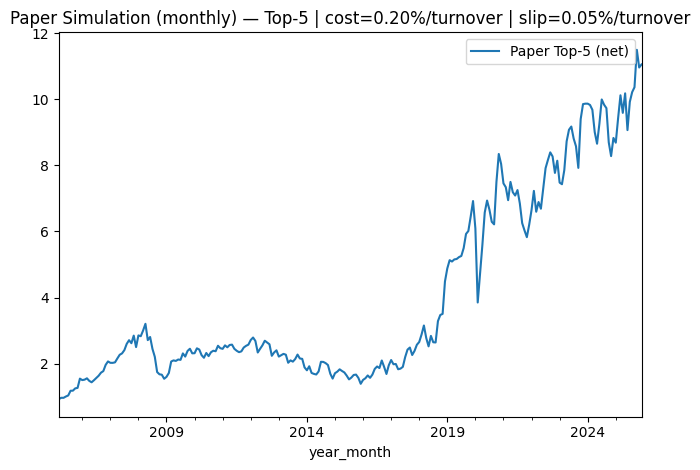

In [6]:
def perf_stats(returns: pd.Series) -> dict:
    returns = returns.dropna()
    equity = (1 + returns).cumprod()
    cum = float(equity.iloc[-1] - 1) if len(equity) else np.nan
    mean = float(returns.mean()) if len(returns) else np.nan
    vol = float(returns.std()) if len(returns) else np.nan
    sharpe = float(mean / vol * np.sqrt(12)) if vol and vol > 0 else np.nan
    dd = (equity / equity.cummax()) - 1
    max_dd = float(dd.min()) if len(dd) else np.nan
    return {"Months": int(len(returns)), "Cumulative": cum, "Mean": mean, "Vol": vol, "Sharpe": sharpe, "MaxDD": max_dd}

print("=== PAPER LONG-ONLY Top-K (net) ===")
print(perf_stats(paper["net_ret"]))
print("Avg turnover:", paper["turnover"].mean())
print("Avg cost:", paper["cost"].mean(), "| Avg slippage:", paper["slippage"].mean())

plt.figure()
(1 + paper["net_ret"]).cumprod().plot(label=f"Paper Top-{K} (net)")
plt.title(f"Paper Simulation (monthly) — Top-{K} | cost={COST*100:.2f}%/turnover | slip={SLIP*100:.2f}%/turnover")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
paper.tail(12)

,gross_ret,net_ret,turnover,cost,slippage
year_month,,,,,
2025-01,-0.015228,-0.016228,0.4,0.0008,0.0002
2025-02,0.086977,0.085477,0.6,0.0012,0.0003
2025-03,0.074885,0.073385,0.6,0.0012,0.0003
2025-04,-0.051024,-0.052524,0.6,0.0012,0.0003
2025-05,0.063080,0.061580,0.6,0.0012,0.0003
2025-06,-0.106796,-0.109296,1.0,0.0020,0.0005
2025-07,0.095213,0.094213,0.4,0.0008,0.0002
2025-08,0.031228,0.029728,0.6,0.0012,0.0003
2025-09,0.015996,0.014496,0.6,0.0012,0.0003


In [8]:
(1 + paper["net_ret"]).cumprod().tail()

year_month
2025-08    10.218895
2025-09    10.367025
2025-10    11.500542
2025-11    10.964769
2025-12    11.056431
Freq: M, Name: net_ret, dtype: float64